In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
data_dir = './Downloads/archive/brain_tumor_dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)
df

,filepaths,labels
0,./Downloads/archive/brain_tumor_dataset\no\1 n...,no
1,./Downloads/archive/brain_tumor_dataset\no\10 ...,no
2,./Downloads/archive/brain_tumor_dataset\no\11 ...,no
3,./Downloads/archive/brain_tumor_dataset\no\12 ...,no
4,./Downloads/archive/brain_tumor_dataset\no\13 ...,no
...,...,...
248,./Downloads/archive/brain_tumor_dataset\yes\Y9...,yes
249,./Downloads/archive/brain_tumor_dataset\yes\Y9...,yes
250,./Downloads/archive/brain_tumor_dataset\yes\Y9...,yes
251,./Downloads/archive/brain_tumor_dataset\yes\Y9...,yes


In [3]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

In [4]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


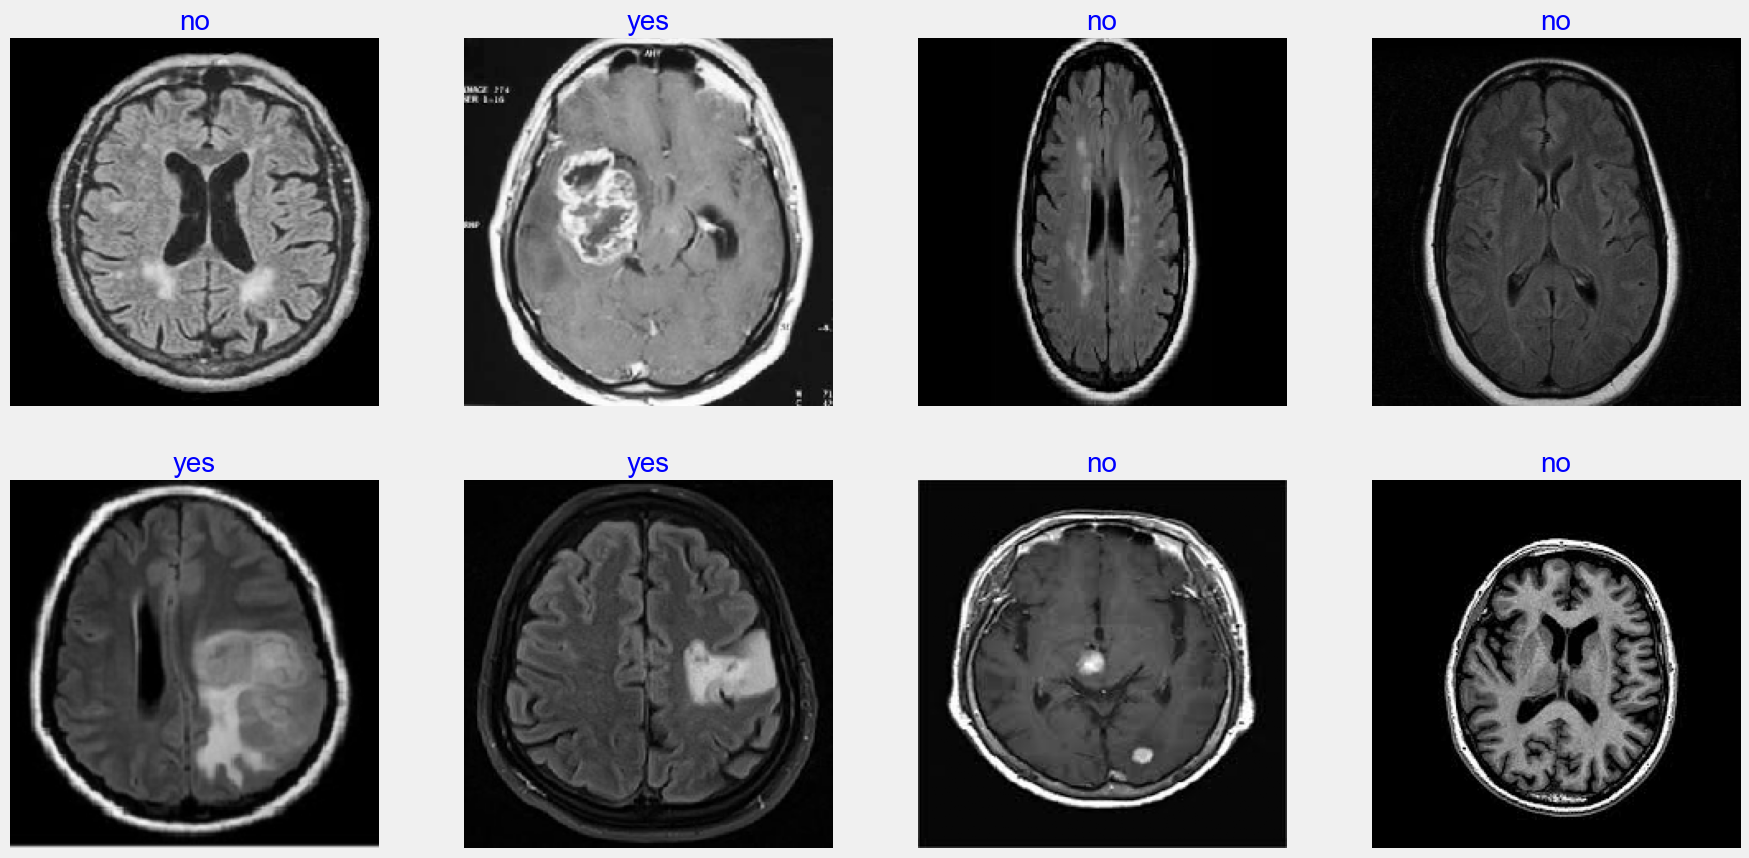

In [13]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 10))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 20)
    plt.axis('off')
plt.show()

In [6]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", 
                                                               input_shape= img_shape, pooling= 'max')


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11183665 (42.66 MB)
Trainable params: 1109

In [7]:
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/10
26/26 [==============================] - 330s 8s/step - loss: 8.3337 - accuracy: 0.7129 - val_loss: 8.8012 - val_accuracy: 0.7647
Epoch 2/10
26/26 [==============================] - 133s 5s/step - loss: 7.2268 - accuracy: 0.8465 - val_loss: 7.9665 - val_accuracy: 0.7647
Epoch 3/10
26/26 [==============================] - 136s 5s/step - loss: 6.7466 - accuracy: 0.8861 - val_loss: 6.9933 - val_accuracy: 0.8235
Epoch 4/10
26/26 [==============================] - 136s 5s/step - loss: 6.3334 - accuracy: 0.8960 - val_loss: 6.6083 - val_accuracy: 0.8039
Epoch 5/10
26/26 [==============================] - 138s 5s/step - loss: 6.0090 - accuracy: 0.9158 - val_loss: 6.0482 - val_accuracy: 0.8627
Epoch 6/10
26/26 [==============================] - 138s 5s/step - loss: 5.6986 - accuracy: 0.9208 - val_loss: 5.7094 - val_accuracy: 0.9216
Epoch 7/10
26/26 [==============================] - 137s 5s/step - loss: 5.4557 - accuracy: 0.9257 - val_loss: 5.4196 - val_accuracy: 0.9412
Epoch 8/10
26

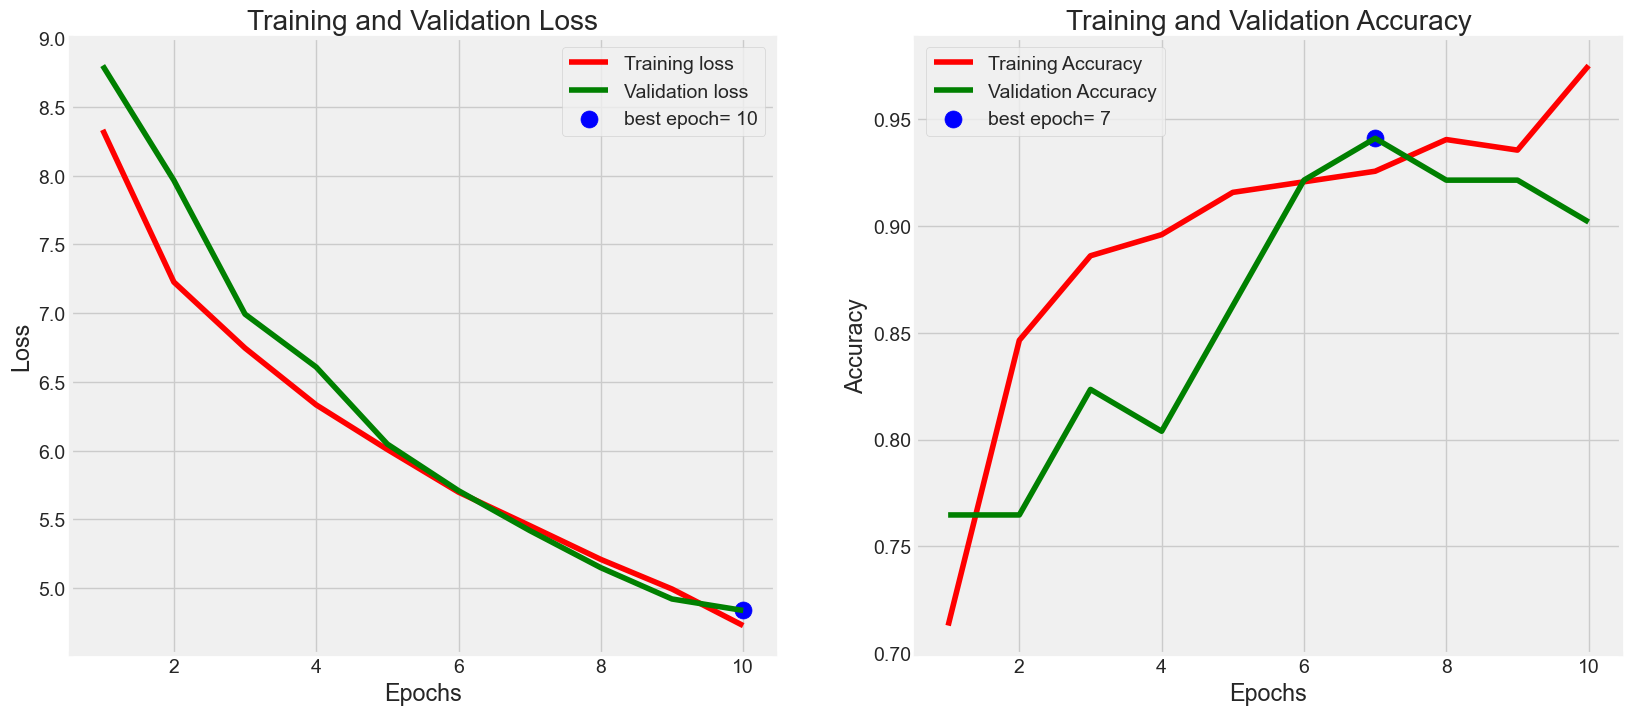

In [8]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [9]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 [==============================] - 7s 972ms/step - loss: 4.8381 - accuracy: 0.9020
Train Loss:  4.63992977142334
Train Accuracy:  0.9950494766235352
--------------------
Test Loss:  4.838086128234863
Test Accuracy:  0.9019607901573181


In [10]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

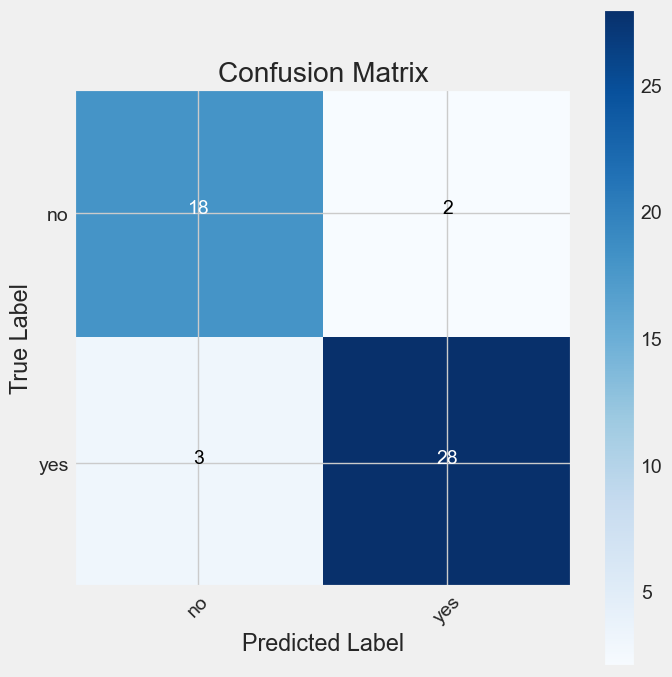

In [11]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (7, 7))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

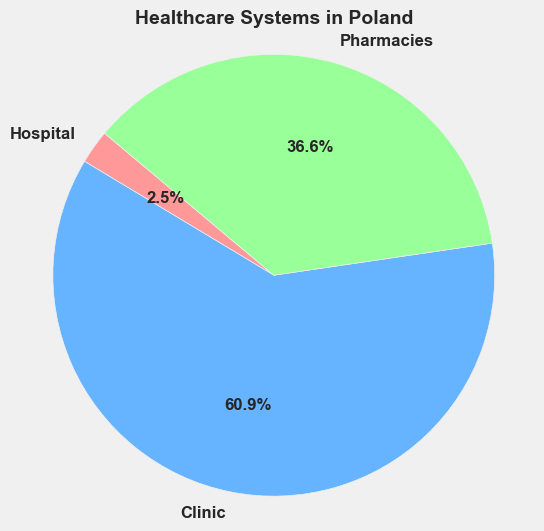

In [16]:


# Data
labels = ['Hospital', 'Clinic', 'Pharmacies']
sizes = [899, 22000, 13200]

# Create a pie chart with a white background
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct=lambda p: '{:.1f}%'.format(p), startangle=140,
       textprops={'fontweight': 'bold', 'fontsize': 12}, colors=['#ff9999', '#66b3ff', '#99ff99'])
ax.set_title('Healthcare Systems in Poland', fontsize=14, fontweight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

# Display the chart
plt.show()